In [33]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

In [3]:
filename = '/Users/enjlife/machine-learning/machinelearninginaction/ch09/ex00.txt'
filename1 = '/Users/enjlife/machine-learning/machinelearninginaction/ch09/ex0.txt'
filename2 = '/Users/enjlife/machine-learning/machinelearninginaction/ch09/ex2.txt'
filename3 = '/Users/enjlife/machine-learning/machinelearninginaction/ch09/ex2test.txt'
filename4 = '/Users/enjlife/machine-learning/machinelearninginaction/ch09/exp2.txt'
filename5 = '/Users/enjlife/machine-learning/machinelearninginaction/ch09/bikeSpeedVsIq_train.txt'
filename6 = '/Users/enjlife/machine-learning/machinelearninginaction/ch09/bikeSpeedVsIq_test.txt'
filename7 = '/Users/enjlife/machine-learning/machinelearninginaction/ch09/sine.txt'

In [5]:
def loaddata(filename):
    data = []
    with open(filename) as fr:
        for line in fr.readlines():
            cur = line.strip().split()
            fltline = list(map(float,cur))
            data.append(fltline)
        return np.array(data)

In [8]:
def binsplit(data,feature,value):#根据特征和特征值进行切分数据集
    mat0 = data[np.nonzero(data[:,feature] > value)[0],:]
    mat1 = data[np.nonzero(data[:,feature] <= value)[0],:]
    return mat0,mat1
def createtree(data,leaftype=regleaf,errtype=regerr,ops=(1,4)):
    feat,val = bestsplit(data,leaftype,errtype,ops)#获取最佳切分特征和特征值，如果没有，则返回None和叶子节点
    if feat == None: return val
    tree = {}
    tree['spind'] = feat
    tree['spval'] = val
    lset,rset = binsplit(data,feat,val)
    tree['left'] = createtree(lset,leaftype,errtype,ops)
    tree['right'] = createtree(rset,leaftype,errtype,ops)
    return tree
    

In [7]:
def regleaf(data):
    return np.mean(data[:,-1])#若不宜再划分，直接返回目标变量的均值作为估计
def regerr(data):
    return np.var(data[:,-1])*data.shape[0]#均方误差

In [9]:
def bestsplit(data,leaftype=regleaf,errtype=regerr,ops=(1,4)):
    tols=ops[0]
    toln=ops[1]
    #print(set(data[:,-1].T.tolist()))
    if len(set(data[:,-1].T.tolist()))==1:
        return None,leaftype(data)
    m,n = data.shape
    S = errtype(data)
    bests = float('inf')
    bestidx = 0
    bestval = 0
    for idx in range(n-1):
        for val in set(data[:,idx]):
            mat0,mat1 = binsplit(data,idx,val)
            if mat0.shape[0]<toln or mat1.shape[0]<toln :
                continue
            news = errtype(mat0)+errtype(mat1)
            if news<bests:#这里初始beats改为以整理均值计算得到的方差比较好？
                bestidx = idx
                bestval = val
                bests = news
    if (S-bests)<tols:#一种预剪枝的方式，当方差减小过小时或者没有减小，同样直接返回叶子节点
        return None,leaftype(data)
    mat0,mat1 = binsplit(data,bestidx,bestval)
    if (mat0.shape[0]<toln) or (mat1.shape[0]<toln):
        return None,leaftype(data)
    return bestidx,bestval         

In [81]:
data = loaddata(filename)
data1 = loaddata(filename1)
data2 = loaddata(filename2)
test = loaddata(filename3)
data3 = loaddata(filename4)

In [12]:
mdata = loaddata(filename5)
mtest = loaddata(filename6)
tkdata = loaddata(filename7)

In [52]:
createtree(data1)

{'left': {'left': {'left': 3.9871632,
   'right': 2.9836209534883724,
   'spind': 1,
   'spval': 0.797583},
  'right': 1.980035071428571,
  'spind': 1,
  'spval': 0.582002},
 'right': {'left': 1.0289583666666666,
  'right': -0.023838155555555553,
  'spind': 1,
  'spval': 0.197834},
 'spind': 1,
 'spval': 0.39435}

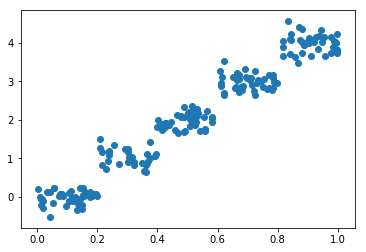

In [58]:
plt.figure()
plt.scatter(data1[:,1],data1[:,2])
plt.show()

预剪枝，通过设定ops参数，误差变化和子集个数来去除臃肿的枝叶，这种方式对于参数调节十分敏感。  
后剪枝，通过测试集来判断生成的叶节点合并能否降低测试误差

In [13]:
def istree(obj):#判断是否为叶子节点
    return (type(obj).__name__=='dict')

In [14]:
def getmean(tree):
    if istree(tree['right']): tree['right'] = getmean(tree['right'])
    if istree(tree['left']): tree['left'] = getmean(tree['left'])
    return (tree['right']+tree['left'])/2.0

In [15]:
def prune(tree,testdata):
    if testdata.shape[0]==0: return getmean(tree)#如果没有测试数据，做塌陷处理
    if (istree(tree['right']) or istree(tree['left'])):
        lset,rset = binsplit(testdata,tree['spind'],tree['spval'])
    if istree(tree['left']): tree['left'] = prune(tree['left'],lset)#有一颗istree则迭代下去直到叶子节点
    if istree(tree['right']): tree['right'] = prune(tree['right'],rset)
    if not istree(tree['left']) and not istree(tree['right']):
        lset,rset = binsplit(testdata,tree['spind'],tree['spval'])
        errornome = np.sum(np.square(lset[:,-1]-tree['left']))+np.sum(np.square(rset[:,-1]-tree['right']))#左子叶和右子叶分别是返回的均值，这里计算均方误差
        treemean = (tree['left']+tree['right'])/2.0
        errorme = np.sum(np.square(testdata[:,-1]-treemean))#计算merge后的均方误差
        if errorme < errornome:
            print('merging')
            return treemean#merge后返回一个均值估计
        else: return tree
    else: return tree

In [69]:
tree = createtree(data2,ops=(0,1))

In [74]:
tree1 = prune(tree,test)

In [89]:
data3.shape

(200, 2)

生成模型树

In [16]:
def linear(data):
    m,n = data.shape
    x = np.ones((m,n))
    y = np.ones((m,1))
    x[:,1:n] = data[:,0:n-1]#这里增加了一列1，相当于常数项
    y = data[:,-1]
    xtx = np.dot(x.T,x)
    #print(xtx.shape)
    if np.linalg.det(xtx)==0.0:
        raise NameError('cannot do inverse, try increase the second value of ops')
    ws = np.dot(np.linalg.inv(xtx),np.dot(x.T,y))
    return ws,x,y
def modelleaf(data):
    ws,x,y = linear(data)
    return ws
def modelerr(data):
    ws,x,y = linear(data)
    yhat = np.dot(x,ws)
    error = np.sum(np.square(y-yhat))
    return error

In [100]:
tree = createtree(data3,modelleaf,modelerr,(1,10))

In [92]:
tree

{'left': array([1.69855694e-03, 1.19647739e+01]),
 'right': array([3.46877936, 1.18521743]),
 'spind': 0,
 'spval': 0.285477}

In [17]:
def regeval(model,data):
    return float(model)
def modeltreeeval(model,data):#这里每次循环执行一条数据
    n = data.shape[1]
    x = np.ones((1,n+1))
    x[:,1:n+1] = data
    return np.dot(x,model).astype(float)
def treefore(tree,data,modeleval=regeval):
    if not istree: return modeleval(tree,data)
    if data[:,tree['spind']]>tree['spval']:
        if istree(tree['left']):
            return treefore(tree['left'],data,modeleval)
        else: return modeleval(tree['left'],data)
    else:
        if istree(tree['right']):
            return treefore(tree['right'],data,modeleval)
        else: return modeleval(tree['right'],data)
def createfore(tree,testdata,modeleval=regeval):
    m = testdata.shape[0]
    yhat = np.zeros((m,1))
    for i in range(m):
        yhat[i,:] = treefore(tree,np.expand_dims(testdata[i],1),modeleval)
    return yhat

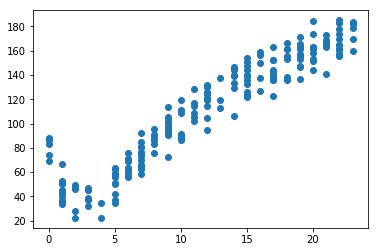

In [166]:
#print('{0}{1}'.format(mdata.shape,mtest))
plt.figure()
plt.scatter(mdata[:,0],mdata[:,1])
plt.show()

**比较三种模型**

In [182]:
#回归树
tree1 = createtree(mdata,ops=(1.0,10))
yhat1 = createfore(tree1,np.expand_dims(mtest[:,0],1),modeleval=regeval)
cor1 = np.corrcoef(yhat1,mtest[:,1],rowvar=0)[0,1]
print(cor1)

0.9640852318222141


In [185]:
#模型树
tree2 = createtree(mdata,modelleaf,modelerr,ops=(1,20))
yhat2 = createfore(tree2,np.expand_dims(mtest[:,0],1),modeleval=modeltreeeval)
cor2 = np.corrcoef(yhat2,mtest[:,1],rowvar=0)[0,1]
print(cor2)

0.9760412191380623


In [194]:
#线性回归
ws,x,y = linear(mdata)
m = x.shape[0]
yhat3 = np.zeros((m,1))
for i in range(m):
    yhat3[i,:] = mtest[i,0]*ws[1]+ws[0]
cor3 = np.corrcoef(yhat3,mtest[:,1],rowvar=0)[0,1]
print(cor3)

0.9434684235674758


In [18]:
import tkinter as tk

In [200]:
#测试学习tkinter
root = tk.Tk()
root.title('new')
thelabel = tk.Label(root,text='tiyanyixia')
thelabel.pack()
root.mainloop()

In [49]:
def reDraw(tols,toln):
    reDraw.f = Figure(figsize=(5,4),dpi=100)
    reDraw.canvas = FigureCanvasTkAgg(reDraw.f,master=root)#将figure显示在tkinter上
    #reDraw.canvas.draw()# draw the picture
    reDraw.canvas.get_tk_widget().grid(row=0,columnspan=3)
    reDraw.f.clf()
    reDraw.a = reDraw.f.add_subplot(111)
    if chkvar.get():
        if toln<2: toln=2
        mytree = createtree(reDraw.rawdat,modelleaf,modelerr,(tols,toln))
        yhat = createfore(mytree,reDraw.testdat,modeltreeeval)
    else:
        mytree = createtree(reDraw.rawdat,ops=(tols,toln))
        yhat = createfore(mytree,reDraw.testdat)
    reDraw.a.scatter(reDraw.rawdat[:,0],reDraw.rawdat[:,1],s=5)
    reDraw.a.plot(reDraw.testdat,yhat,linewidth=2.0)
    reDraw.canvas.draw()
def getinputs():
    #print(int(tolnentry.get()))
    try: toln = int(float(tolnentry.get()))
    except:
        toln = 10
        print('enter integer for toln')
        tolnentry.delete(0,END)
        tolnentry.insert(0,'10')
    try: tols = float(tolsentry.get())
    except:
        tols = 1.0
        print('enter float for tols')
        tolsentry.delete(0,END)
        tolsentry.insert(0,'1.0')
    return toln,tols
def drawNewtree():
    toln,tols = getinputs()
    reDraw(tols,toln)
root = tk.Tk()
tk.Label(root,text='Plot Place Holder').grid(row=0,columnspan=3)
tk.Label(root,text='toln').grid(row=1,column=0)
tolnentry = tk.Entry(root)
tolnentry.grid(row=1,column=1)
tolnentry.insert(0,'10')
tk.Label(root,text='tols').grid(row=2,column=0)
tolsentry = tk.Entry(root)
tolsentry.grid(row=2,column=1)
tolsentry.insert(0,'1.0')
tk.Button(root,text='ReDraw',command=drawNewtree).grid(row=1,column=2,rowspan=3)#点击ReDraw按钮，画新树
chkvar = tk.IntVar()
chkbtn = tk.Checkbutton(root,text='Model Tree',variable=chkvar)
chkbtn.grid(row=3,column=0,columnspan=2)
reDraw.rawdat = tkdata
reDraw.testdat = np.linspace(np.min(reDraw.rawdat[:,0]),np.max(reDraw.rawdat[:,0]),int((np.max(reDraw.rawdat[:,0])-np.min(reDraw.rawdat[:,0]))/0.01))
reDraw.testdat = np.expand_dims(reDraw.testdat,1)
reDraw(1.0,10)
root.mainloop()

20
10
20
20
10
5
5
10
10
20
20
20
40
150


Exception in Tkinter callback
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/tkinter/__init__.py", line 1699, in __call__
    return self.func(*args)
  File "<ipython-input-49-3a69a08ebc80>", line 35, in drawNewtree
    reDraw(tols,toln)
  File "<ipython-input-49-3a69a08ebc80>", line 11, in reDraw
    yhat = createfore(mytree,reDraw.testdat,modeltreeeval)
  File "<ipython-input-17-c80b112affaa>", line 22, in createfore
    yhat[i,:] = treefore(tree,np.expand_dims(testdata[i],1),modeleval)
  File "<ipython-input-17-c80b112affaa>", line 10, in treefore
    if data[:,tree['spind']]>tree['spval']:
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


10
5
1
50
40
30
10
10
50


In [45]:
a = np.array([1,2,3])
print(a.shape)
b = np.transpose(a)
b.shape

(3,)


(3,)

In [40]:
testdat

NameError: name 'testdat' is not defined